In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import os
import re
import nltk

# --- BERTopic and ML Libraries ---
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

# --- Google Generative AI for API-based representation ---
import google.generativeai as genai
from dotenv import load_dotenv


# --- Visualization ---
import datamapplot

# --- API Key Configuration ---

load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")
if not api_key:
    raise ValueError("API key not found in .env file.")
genai.configure(api_key=api_key)

# --- NLTK Data Download ---
nltk.download('punkt')
print("Setup complete.")

Setup complete.


[nltk_data] Downloading package punkt to /Users/rbeaute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Path to your data file
csv_path = '/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/MPE_dataset_translated_batched.csv'
df = pd.read_csv(csv_path)

df.dropna(subset=['phen_report_english'], inplace=True)
df = df[df.phen_report_english.str.strip() != '']

# --- Document Preparation ---
reports = df['phen_report_english'].tolist()
print(f"Loaded {len(reports)} (translated) documents for BERTopic modeling.")

# Divide each report into sentences, same as before
reports_sentences = [nltk.sent_tokenize(report) for report in reports]
sentences = [sentence for report in reports_sentences for sentence in report]
print(f"Total number of sentences across all reports: {len(sentences)}")

# Set documents to sentences for topic modeling
docs = sentences

Loaded 830 (translated) documents for BERTopic modeling.
Total number of sentences across all reports: 6107


### local (no API) using LLama3

In [4]:

from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison


# --- Embedding Model (Same as mpe_llama.ipynb) ---
embedding_model = SentenceTransformer("BAAI/bge-small-en-v1.5")

# --- Vectorizer Model (Same as mpe_llama.ipynb) ---
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words='english')

# --- Dimensionality Reduction & Clustering (Same as mpe_llama.ipynb) ---
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom', prediction_data=True)


# --- LLM Representation Model (Using Google Gemini API) ---
# The prompt is adapted slightly for Gemini models.
# We will use 'gemini-1.5-flash-latest' which is fast and cost-effective.
# prompt = """
# I have a topic that contains the following documents:
# [DOCUMENTS]

# Based on these documents, please generate a concise and descriptive label for this topic.
# The label should be a short phrase, ideally 3-5 words long.
# Return ONLY the label itself, without any introductory text or quotation marks.
# """

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]


The topic is described by the following keywords: '[KEYWORDS]'.


Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""



# # Use the built-in BERTopic module for Google Generative AI
# representation_model = GoogleGenerativeAI(
#     model="gemini-1.5-flash-latest",
#     prompt=prompt,
#     delay_in_seconds=2 # To avoid hitting API rate limits
# )

model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)


# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, 
            n_gpu_layers=-1, #offload all possible layers of the model to the GPU
            n_ctx=4096, 
            stop=["Q:", "\n"],
            verbose=False)


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


print("BERTopic components defined, using Llama API for representation.")

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

BERTopic components defined, using Llama API for representation.


### API version (using Gemini)

In [5]:
# --- LLM Representation Model (Using Custom Class for Google Gemini API) ---


import time
from bertopic.representation import BaseRepresentation



class GeminiRepresentation(BaseRepresentation):
    def __init__(self):
        super().__init__()
        self.model = genai.GenerativeModel('gemini-1.5-pro-latest') # Or 'gemini-1.5-flash-latest' for speed
        self.prompt = (
            "I have a topic that contains the following documents:\n[DOCUMENTS]\n\n"
            "Based on these documents, what is a concise, descriptive, and insightful label for this topic? "
            "The label should be a short phrase, ideally 3-5 words. "
            "Return ONLY the label itself, with no extra commentary or quotation marks."
        )
        self.delay_in_seconds = 2 # Delay to avoid hitting API rate limits

    def extract_topics(self, topic_model, documents, c_tf_idf, topics):
        repr_docs_by_topic = topic_model.get_representative_docs()

        for topic_id, docs_indices in repr_docs_by_topic.items():
            if topic_id == -1: continue # Skip outlier topic

            # --- THIS IS THE CORRECTED LINE ---
            # Access the 'Document' column from the documents DataFrame using .iloc
            doc_texts = [documents.Document.iloc[i] for i in docs_indices]
            doc_string = "\n---\n".join(doc_texts)
            
            try:
                # Add a small delay to avoid hitting API rate limits
                time.sleep(self.delay_in_seconds)
                response = self.model.generate_content(self.prompt.replace("[DOCUMENTS]", doc_string))
                topic_label = response.text.strip().replace('"', '')
                topics[topic_id] = [(topic_label, 1.0)]
            except Exception as e:
                error_message = str(e).split('\n')[0]
                print(f"Error generating label for topic {topic_id}: {error_message}")
                topics[topic_id] = [(f"Error: {error_message[:30]}...", 1.0)]
                
        return topics

# --- Your representation_model dictionary remains the same ---
# It's set up correctly to run all three models.
representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
    "Gemini": GeminiRepresentation()
}

print("BERTopic components defined with the CORRECTED GeminiRepresentation class.")




BERTopic components defined with the CORRECTED GeminiRepresentation class.


In [6]:
print("Pre-calculating embeddings...")
# Pre-calculate embeddings for efficiency (same as original notebook)
embeddings = embedding_model.encode(docs, show_progress_bar=True)
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)


print("Instantiating and training BERTopic model...")
topic_model = BERTopic(
    # Sub-models
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    
    # Hyperparameters (same as original notebook)
    top_n_words=10,
    verbose=True
)

# Train the model
topics, probs = topic_model.fit_transform(docs, embeddings)

print("\n--- MODEL TRAINING COMPLETE ---")
# Show topics
print("Final topics generated by BERTopic and labeled by Gemini:")
topic_model.get_topic_info()

Pre-calculating embeddings...


Batches:   0%|          | 0/191 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-06-28 19:10:03,106 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Instantiating and training BERTopic model...


2025-06-28 19:10:11,148 - BERTopic - Dimensionality - Completed ✓
2025-06-28 19:10:11,149 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-28 19:10:11,371 - BERTopic - Cluster - Completed ✓
2025-06-28 19:10:11,374 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 15/15 [00:28<00:00,  1.89s/it]
2025-06-28 19:10:42,453 - BERTopic - Representation - Completed ✓



--- MODEL TRAINING COMPLETE ---
Final topics generated by BERTopic and labeled by Gemini:


,Topic,Count,Name,Representation,KeyBERT,LLM,Gemini,Representative_Docs
0,-1,3318,-1_experience_feeling_awareness_body,"[experience, feeling, awareness, body, like, f...","[body, feel, fullness, self, feeling, sensatio...","[""Transcendent States of Consciousness"", , , ,...","[experience, feeling, awareness, body, like, f...","[It has always been like this., I have a body...."
1,0,853,0_meditation_experience_retreat_meditating,"[meditation, experience, retreat, meditating, ...","[meditation experience, experience meditation,...","[""Exploring Pure Awareness in Meditation"", , ,...","[meditation, experience, retreat, meditating, ...","[In morning meditation, I am in being., My exp..."
2,1,307,1_peace_feeling_joy_deep,"[peace, feeling, joy, deep, love, bliss, peace...","[peace feeling, feeling peace, deep peace, tra...","[""Experience of Inner Peacefulness"", , , , , ,...","[peace, feeling, joy, deep, love, bliss, peace...","[A feeling of complete peace with what is., An..."
3,2,280,2_thoughts_self_sense_fear,"[thoughts, self, sense, fear, simply, feelings...","[thoughts hardly, nothingness, self, sense sel...","[""Mindfulness and Non-Self Awareness"", , , , ,...","[thoughts, self, sense, fear, simply, feelings...","[Identity, I, narratives were not present, the..."
4,3,167,3_pure_awareness_experience_consciousness,"[pure, awareness, experience, consciousness, p...","[experience pure consciousness, experience pur...","[""Experiences of Pure Consciousness"", , , , , ...","[pure, awareness, experience, consciousness, p...",[I will describe my first big experience of pu...
5,4,163,4_good_just_simply_presence,"[good, just, simply, presence, existence, abso...","[absolute presence, certainty, pure existence,...","[""Embracing the Present with Respect"", , , , ,...","[good, just, simply, presence, existence, abso...","[1) A state of perfection, of absolute clarity..."
6,5,159,5_awareness_felt_aware_trees,"[awareness, felt, aware, trees, like, wind, na...","[felt like awareness, felt aware, time felt, f...","[""Expanding Awareness in Nature"", , , , , , , ...","[awareness, felt, aware, trees, like, wind, na...","[About the experience, so I was in the superma..."
7,6,150,6_time_lasted_minutes_state,"[time, lasted, minutes, state, sense time, hou...","[time didn exist, time didn, lost sense time, ...","[""Perception of Time and Space"", , , , , , , ,...","[time, lasted, minutes, state, sense time, hou...","[There was no sense of time., I had no sense o..."
8,7,143,7_thoughts_awareness_mind_pure awareness,"[thoughts, awareness, mind, pure awareness, pu...","[thoughts come complete, awareness aware thoug...","[""Mindfulness and Pure Awareness State"", , , ,...","[thoughts, awareness, mind, pure awareness, pu...","[In the state of pure awareness, thoughts come..."
9,8,135,8_dream_lucid_awake_sleep,"[dream, lucid, awake, sleep, waking, lucid dre...","[lucid dream, lucid dreaming, experience lucid...","[""Exploring Lucid Dreaming Experience"", , , , ...","[dream, lucid, awake, sleep, waking, lucid dre...",[I then remembered - in the dream - the instru...


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `llama-3-8b-instruct`'}>)

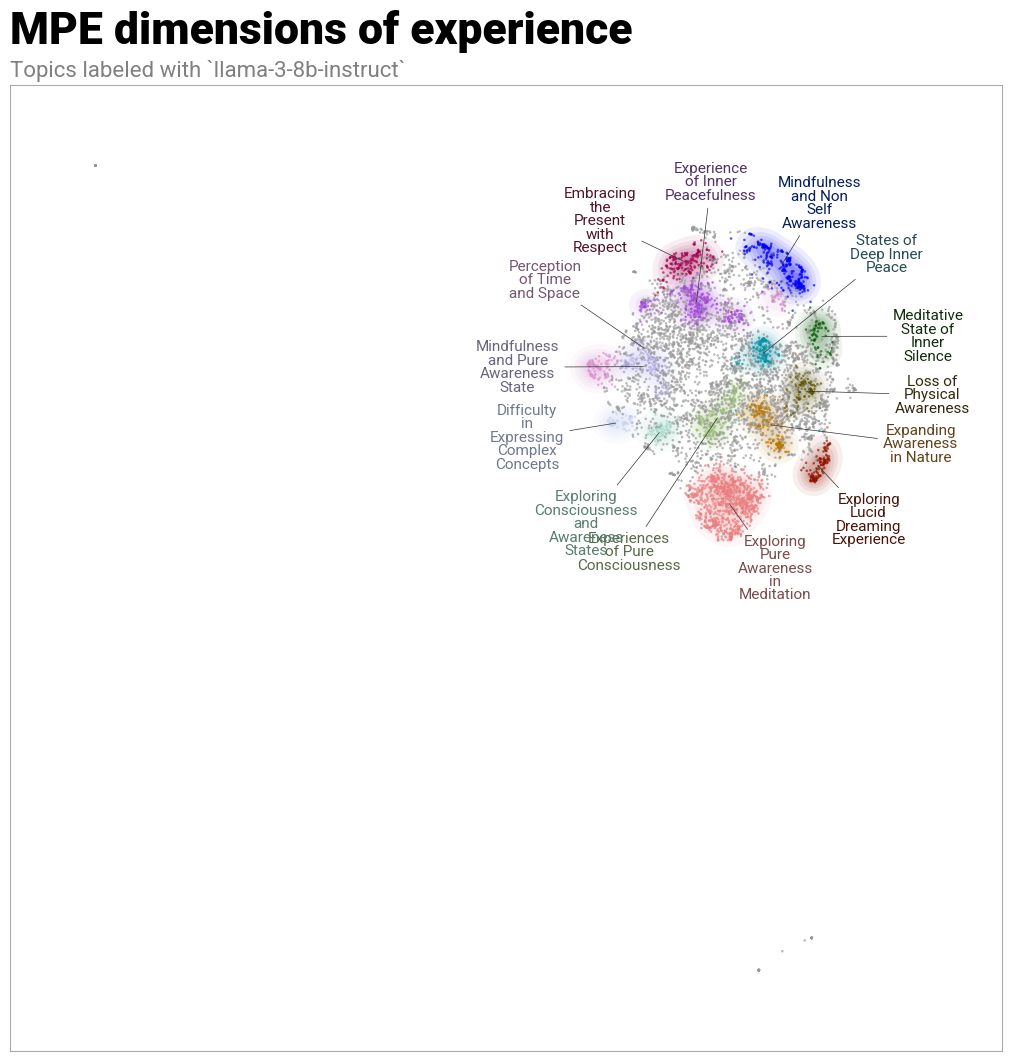

In [7]:
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]


# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title="MPE dimensions of experience",
   sub_title="Topics labeled with `llama-3-8b-instruct`",
   label_wrap_width=10
)